In [67]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Defining methods to join bike_data and weather data

In [2]:
def cut_timestamp(timestamp_col):
    return timestamp_col.map(lambda x:int(str(x)[:10]))

def assemble_timestamp_cut(day_frame, time_frame):
    day_clean = day_frame.map(lambda x: x.replace("-", ""))
    hour = time_frame.map(lambda x: x.replace(":", "")[:2])
    return (day_clean + hour).astype("int64")

def join_by_hour(bike_frame, weather_frame, column_name):
    bike_frame["timestamp_cut"] = assemble_timestamp_cut(bike_frame["day"], bike_frame["time"])
    weather_frame["timestamp_cut"] = cut_timestamp(weather_frame["Zeitstempel"])
    
    joined = bike_frame.join(weather_frame[["Wert", "timestamp_cut"]].set_index("timestamp_cut"), on="timestamp_cut")
    joined[column_name] = joined["Wert"]
    
    joined = joined.drop("Wert", axis=1)
    joined = joined.drop("timestamp_cut", axis=1)
    
    return joined

In [27]:
brm_frame = pd.read_csv("resources/bremen.csv")
brm_precipitation = pd.read_csv("resources/bremen_precipitation.csv")
brm_temperature = pd.read_csv("resources/bremen_temperature.csv")
schwarme_precipitation = pd.read_csv("resources/schwarme_precipitation.csv")
bassum_precipitation = pd.read_csv("resources/bassum_precipitation.csv")

brm_precipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8775 entries, 0 to 8774
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Produkt_Code      8775 non-null   object 
 1   SDO_ID            8775 non-null   int64  
 2   Zeitstempel       8775 non-null   int64  
 3   Wert              8775 non-null   float64
 4   Qualitaet_Niveau  8775 non-null   int64  
 5   Qualitaet_Byte    8775 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 411.5+ KB


Identifying missing values

In [61]:
# loading precipitation data of bremen and mark missing values
brm_precipitation_full = brm_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
brm_precipitation_full = brm_precipitation_full.set_index("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.sort_values("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.reset_index()

brm_precipitation_full[brm_precipitation_full["Wert"].isnull()]

,Zeitstempel,Produkt_Code,SDO_ID,Wert,Qualitaet_Niveau,Qualitaet_Byte
439,201902070700,NaN,NaN,NaN,NaN,NaN
440,201902070800,NaN,NaN,NaN,NaN,NaN
441,201902070900,NaN,NaN,NaN,NaN,NaN
442,201902071000,NaN,NaN,NaN,NaN,NaN
443,201902071100,NaN,NaN,NaN,NaN,NaN
452,201902072000,NaN,NaN,NaN,NaN,NaN
453,201902072100,NaN,NaN,NaN,NaN,NaN
454,201902072200,NaN,NaN,NaN,NaN,NaN
455,201902072300,NaN,NaN,NaN,NaN,NaN


In [68]:
brm_sub_frame = brm_precipitation_full[(brm_precipitation_full["Zeitstempel"] >= 201902070000) & (brm_precipitation_full["Zeitstempel"] <= 201902080300)]
brm_sub_frame

,Zeitstempel,Produkt_Code,SDO_ID,Wert,Qualitaet_Niveau,Qualitaet_Byte
432,201902070000,R1_MN008,691.0,0.6,0.0,3.0
433,201902070100,R1_MN008,691.0,1.1,0.0,3.0
434,201902070200,R1_MN008,691.0,1.2,0.0,3.0
435,201902070300,R1_MN008,691.0,1.3,0.0,3.0
436,201902070400,R1_MN008,691.0,1.0,0.0,3.0
437,201902070500,R1_MN008,691.0,0.7,0.0,3.0
438,201902070600,R1_MN008,691.0,0.1,0.0,3.0
439,201902070700,NaN,NaN,NaN,NaN,NaN
440,201902070800,NaN,NaN,NaN,NaN,NaN
441,201902070900,NaN,NaN,NaN,NaN,NaN


## Getting data from station of schwarme and station of bassum

In [55]:
# loading precipitation data of schwarme and mark missing values
schwarme_precipitation_full = schwarme_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
schwarme_precipitation_full = schwarme_precipitation_full.set_index("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.sort_values("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.reset_index()

bassum_precipitation_full = bassum_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
bassum_precipitation_full = bassum_precipitation_full.set_index("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.sort_values("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.reset_index()

## Finding the station which has approximately the same precipitation than the station of bremen

In [70]:
schwarme_sub_frame = schwarme_precipitation_full[(schwarme_precipitation_full["Zeitstempel"] >= 201902070000) & (schwarme_precipitation_full["Zeitstempel"] <= 201902080300)]

In [69]:
bassum_sub_frame = bassum_precipitation_full[(bassum_precipitation_full["Zeitstempel"] >= 201902070000) & (bassum_precipitation_full["Zeitstempel"] <= 201902080300)]

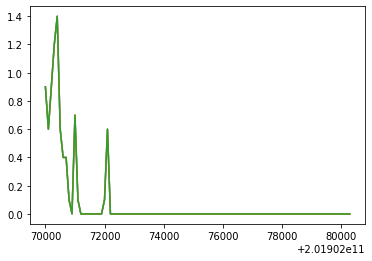

In [76]:

plt.plot(bassum_sub_frame["Zeitstempel"], bassum_sub_frame["Wert"], label="bassum")
plt.plot(brm_sub_frame["Zeitstempel"], bassum_sub_frame["Wert"], label="bremen")
plt.plot(schwarme_sub_frame["Zeitstempel"], bassum_sub_frame["Wert"], label="schwarme")

plt.show()


Since there are missing hours in the weather data, we want to fill these gaps with weater data from the nearest station. 


## combine missing values of brm_precipitation with precipitation values from the city of schwarme

In [19]:
# create a dataframe which contains all dates from 2019-01-20 until 2020-01-20
all_dates_frame = pd.DataFrame(pd.date_range(
    start = datetime.strptime("2019-01-20 00", "%Y-%m-%d %H"), 
    end = datetime.strptime("2020-01-20 00", "%Y-%m-%d %H"),
    freq="1h"), columns=["date"])

all_dates_frame["Zeitstempel"] = all_dates_frame["date"].map(lambda x: int(x.strftime("%Y%m%d%H%M")))
all_dates_frame = all_dates_frame.drop("date", 1)

# loading precipitation data of schwarme and mark missing values
schwarme_precipitation_full = schwarme_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
schwarme_precipitation_full = schwarme_precipitation_full.set_index("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.sort_values("Zeitstempel")

# loading precipitation data of bremen and mark missing values
brm_precipitation_full = brm_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
brm_precipitation_full = brm_precipitation_full.set_index("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.sort_values("Zeitstempel")

# fill missing values from bremen with values of schwerme
brm_precipitation_full[brm_precipitation_full["Wert"].isnull()] = schwarme_precipitation_full

brm_precipitation_combined = brm_precipitation_full
brm_precipitation_combined = brm_precipitation_combined.reset_index()

In [21]:
brm_frame_precipitation = join_by_hour(brm_frame, brm_precipitation_combined, "precipitation")
brm_frame_precipitation

brm_frame_weather = join_by_hour(brm_frame_precipitation, brm_temperature, "temperature")

brm_frame_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157576 entries, 0 to 157575
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            157576 non-null  object 
 1   time           157576 non-null  object 
 2   b_number       157576 non-null  int64  
 3   city           157576 non-null  object 
 4   trip_duration  157576 non-null  object 
 5   orig_lat       157576 non-null  float64
 6   orig_lng       157576 non-null  float64
 7   dest_lat       157576 non-null  float64
 8   dest_lng       157576 non-null  float64
 9   precipitation  157576 non-null  float64
 10  temperature    157576 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 13.2+ MB


In [ ]:
frb_frame = pd.read_csv("resources/freiburg.csv")
frb_precipitation = pd.read_csv("resources/freiburg_precipitation.csv")
frb_temperature = pd.read_csv("resources/freiburg_temperature.csv")

frb_frame_precipitation = join_by_hour(frb_frame, frb_precipitation, "precipitation")
frb_frame_weather = join_by_hour(frb_frame_precipitation, frb_temperature, "temperature")

frb_frame_weather.info()